# `Практикум по программированию на языке Python`

## `Задание 03. Рекуррентные Нейронные Сети. Dropout. LM`

#### Фамилия, имя: Никишкина Евгения

Дата выдачи: <span style="color:red">__03 апреля 04:00__</span>.

Мягкий дедлайн: <span style="color:red">__18 апреля 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __7 баллов__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2023`

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# `Часть 0. Загрузка и предобработка данных (1 балл)`

## `Рекомендуемые гиперпараметры`

In [76]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать — скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## `Загрузка и предобработка данных`

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [77]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-04-20 15:31:02--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  19.7MB/s    in 7.4s    

2023-04-20 15:31:10 (10.9 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [78]:
!tar -xf aclImdb_v1.tar.gz -C .

Посмотрите в файле `./aclImdb/README` как организованы данные:

In [79]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [80]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [81]:
import os
from functools import partial
from collections import defaultdict

import nltk
nltk.download('stopwords')

import regex
import numpy as np

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти — размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [82]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`, ...)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [83]:
def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    # YOUR CODE HERE
    text = text.lower()
    text = regex.sub(r'\<[^>]*\>', ' ', text)
    text = regex.sub('[^a-z]', ' ', text)
    text = text.split(' ')
    text = [word for word in text if word not in STOPWORDS and word != '']
    
    return text
    

In [84]:
tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

Теперь мы можем создать словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab` и фабрика для создания таких классов `torchtext.vocab.vocab`.

In [85]:
torchtext.vocab.vocab??

Signature:
torchtext.vocab.vocab(
    ordered_dict: Dict,
    min_freq: int = 1,
    specials: Union[List[str], NoneType] = None,
    special_first: bool = True,
) -> torchtext.vocab.vocab.Vocab
Source:   
def vocab(
    ordered_dict: Dict, min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True
) -> Vocab:
    r"""Factory method for creating a vocab object which maps tokens to indices.

    Note that the ordering in which key value pairs were inserted in the `ordered_dict` will be respected when building the vocab.
    Therefore if sorting by token frequency is important to the user, the `ordered_dict` should be created in a way to reflect this.

    Args:
        ordered_dict: Ordered Dictionary mapping tokens to their corresponding occurance frequencies.
        min_freq: The minimum frequency needed to include a token in the vocabulary.
        specials: Special symbols to add. The order of supplied tokens will be preserved.
        special_first: Indica

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [86]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [87]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

Создайте словарь из словаря частот `counter`. Наименьшие *id* отдайте под специальные токены. 

Отбросьте низкочастотные слова, оставив только `top_n_words` слов. Можете использовать любой способ реализации этого условия, например:
1. Оставить в словаре `counter` нужное число слов
2. Подобрать параметр `min_freq`, чтобы оставшееся число слов было близко к необходимому порогу

In [88]:
# YOUR CODE HERE
from torchtext.vocab import vocab
from collections import OrderedDict


vocab = vocab(OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True)[:top_n_words]),
              min_freq=0, specials=['<pad>', '<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [89]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [90]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 3, 1, 254]

Теперь мы готовы создать обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от $1$ до $10$. Для удобства, вычтите $1$, чтобы рейтинг был от $0$ до $9$

In [91]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            # YOUR CODE HERE
            with open(path, 'r', encoding='utf-8', errors='ignore') as file:
                text = file.read().strip()
                self.texts.append(text)
                self.tokens.append(vocab.lookup_indices(tokenize(text)))
                rate = int(path[path.find('_') + 1: path.find('.txt')]) - 1
                self.ratings.append(rate)
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.Tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.Tensor(dtype=torch.long): rating of the text
                'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.Tensor(dtype=torch.long): number of tokens
            }
        """
        # YOUR CODE HERE
        # Do not forget to add padding if needed!
        tokens = []
        if self.pad_sos:
            tokens.append(self.sos_id)
        tokens += self.tokens[idx][:self.max_len]
        if self.pad_eos:
            tokens.append(self.eos_id)
        idx_dict = {
            'text': self.texts[idx],
            'label': torch.tensor([self.labels[idx]], dtype=torch.long),
            'rating': torch.tensor([self.ratings[idx]], dtype=torch.long),
            'tokens': torch.tensor(tokens, dtype=torch.long),
            'tokens_len': torch.tensor([len(tokens)], dtype=torch.long)
        }
        return idx_dict
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        # YOUR CODE HERE
        return len(self.texts)

Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [92]:
# YOUR CODE HERE
test_dataset = LargeMovieReviewDataset(test_data_path, vocab, max_length)
train_dataset = LargeMovieReviewDataset(train_data_path, vocab, max_length)

Посмотрим, как выглядит объект в датасете:

In [93]:
test_dataset[0]

{'text': "Hmmmmmmm - cheerleader massacre. Let me think - high school girls get sliced up, except the cute one survives. Got it. Next movie.<br /><br />I was actually surprised this one was made in 2003. I really thought they quit making these movies in the 80's. This was truly your run of the mill slasher movie with teenage eye candy, dumb male horn dogs, even dumber male adult, and hot teacher. It continues on the list of dark and stormy night and abandoned cabin in the woods. We have seen it all before.<br /><br />However this one had a few interesting plot twists that places it above the normal me-too slashers, so if you have got a few brain cells to fry and 2 hours to kill - you could do worse.",
 'label': tensor([0]),
 'rating': tensor([2]),
 'tokens': tensor([   1,    1, 2477,  162,   27,  184,  246,  391,   16,    1,  422,  869,
            4,    1,   89,  248,    2,   65,  619,    4,   21,   11,   90, 4694,
          124,   25,  251,  365, 4208, 1096,    2, 1502,  604, 1801,  

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` — число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [94]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [95]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.Tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.Tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.Tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    # YOUR CODE HERE
    ratings, labels, texts, tokens, tokens_lens = [], [], [], [], []
    for obj in batch:
        ratings.append(obj['rating'])
        labels.append(obj['label'])
        texts.append(obj['text'])
        tokens.append(obj['tokens'])
        tokens_lens.append(obj['tokens_len'])
    data_dict = {
        'texts': texts,
        'labels': torch.tensor(labels, dtype=torch.long),
        'ratings': torch.tensor(ratings, dtype=torch.long),
        'tokens': torch.nn.utils.rnn.pad_sequence(tokens, 
                      batch_first=batch_first, padding_value=padding_value),
        'tokens_lens': torch.tensor(tokens_lens, dtype=torch.long)
    }
    return data_dict
    

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [96]:
# YOUR CODE HERE
from functools import partial
pad_val = vocab.lookup_indices(['<pad>'])[0]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=partial(collate_fn, padding_value=pad_val), num_workers=0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=partial(collate_fn, padding_value=pad_val), num_workers=0, shuffle=True)

Посмотрим на какой-нибудь батч:

In [97]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['texts', 'labels', 'ratings', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([2, 2, 3, 1, 0, 2, 0, 0, 0, 0, 3, 1, 0, 1, 2, 0, 3, 3, 0, 0, 0, 0, 0, 2,
         2, 1, 0, 2, 2, 0, 3, 0, 2, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 1, 3,
         2, 2, 3, 0, 0, 1, 0, 3, 1, 2, 2, 0, 0, 3, 0, 1]),
 tensor([[   1,  518, 1465,  ..., 1194,  269,    1],
         [   1,   56,  150,  ...,    1,    1, 3572],
         [2477,  149, 3230,  ...,  129,    2,    1],
         ...,
         [   0,    0,    0,  ...,   35,    0,    0],
         [   0,    0,    0,  ...,    1,    0,    0],
         [   0,    0,    0,  ...,  223,    0,    0]]),
 tensor([ 69, 120, 134,  43,  75, 196,  57,  16,  29,  52,  61,  54,  87,  59,
         112,  66,  99,  25,  17,  86,  73, 200,  99,  51, 200, 100, 115,  6

# `Часть 1. Классификация текстов (4 балла)`

## `Сборка и обучение RNN в pytorch (1 балл)`

Создадим переменные для device-agnostic кода:

In [98]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-эмбеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации. 
**Не используйте циклы.**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [99]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        # YOUR CODE HERE
        self.word_embeddings = torch.nn.Embedding(num_embeddings=len(vocab), embedding_dim=embedding_dim,
                                                   padding_idx=vocab.lookup_indices(['<pad>'])[0])
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        
        # Create linear layer for classification
        # YOUR CODE HERE
        self.output = torch.nn.Linear(hidden_dim, output_size)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.Tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        # YOUR CODE HERE
        # (max_lenght, batch_size, embedding_dim)
        x = self.word_embeddings(tokens)
        
        # Make forward pass through recurrent network
        # YOUR CODE HERE
        # (max_lenght, batch_size, hidden_dim)
        x = self.rnn(x)[0]
        
        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        # YOUR CODE HERE
        # (batch_size, output_size)
        return self.output(x[tokens_lens - 1, torch.arange(x.shape[1])])

[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [100]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        # YOUR CODE HERE
        optimizer.zero_grad()
        loss = loss_fn(model(data['tokens'].to(device), data['tokens_lens'].to(device)), data['ratings'].to(device))
        loss.backward()
        optimizer.step()
    
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            # YOUR CODE HERE
            pred = model(data['tokens'].to(device), data['tokens_lens'].to(device))
            labels = data['ratings'].to(device)
            loss = loss_fn(pred, labels)
            total_loss += loss_fn(pred, labels).item() * len(pred)
            total_accuracy += (pred.argmax(axis=1) == labels).sum().item()
        
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)
    

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [101]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [102]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [103]:
import time
history = dict()
history['time'], history['train_loss'], history['train_acc'], history['test_loss'], history['test_acc'] = [], [], [], [], []

In [104]:
start = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
history['time'].append(time.time() - start)
history['train_loss'].append(train_losses_pure)
history['train_acc'].append(train_accuracies_pure)
history['test_loss'].append(test_losses_pure)
history['test_acc'].append(test_accuracies_pure)

Epoch: 1/15. Loss (Train/Test): 1.918/1.922. Accuracy (Train/Test): 0.286/0.291
Epoch: 2/15. Loss (Train/Test): 1.689/1.721. Accuracy (Train/Test): 0.353/0.350
Epoch: 3/15. Loss (Train/Test): 1.590/1.647. Accuracy (Train/Test): 0.379/0.361
Epoch: 4/15. Loss (Train/Test): 1.504/1.597. Accuracy (Train/Test): 0.413/0.376
Epoch: 5/15. Loss (Train/Test): 1.447/1.582. Accuracy (Train/Test): 0.428/0.385
Epoch: 6/15. Loss (Train/Test): 1.399/1.579. Accuracy (Train/Test): 0.453/0.381
Epoch: 7/15. Loss (Train/Test): 1.343/1.553. Accuracy (Train/Test): 0.473/0.395
Epoch: 8/15. Loss (Train/Test): 1.282/1.591. Accuracy (Train/Test): 0.491/0.395
Epoch: 9/15. Loss (Train/Test): 1.225/1.584. Accuracy (Train/Test): 0.518/0.396
Epoch: 10/15. Loss (Train/Test): 1.176/1.662. Accuracy (Train/Test): 0.530/0.399
Epoch: 11/15. Loss (Train/Test): 1.126/1.709. Accuracy (Train/Test): 0.557/0.386
Epoch: 12/15. Loss (Train/Test): 1.049/1.735. Accuracy (Train/Test): 0.600/0.374
Epoch: 13/15. Loss (Train/Test): 0.94

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют *L2-регуляризацию* и *дропаут*.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## `Реализация дропаута по статье Гала и Гарамани. Variational Dropout (1 балл)`

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$

In [105]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    # YOUR CODE HERE
    h0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    c0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    return h0, c0

In [106]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    # YOUR CODE HERE
    batch_size = some_existing_tensor.shape[1]
    if p:
        if is_training:
            m_h = torch.bernoulli(some_existing_tensor.new_full((batch_size, hidden_size), 1 - p))
            m_x = torch.bernoulli(some_existing_tensor.new_full((batch_size, input_size), 1 - p))
        else:
            m_h = some_existing_tensor.new_full((batch_size, hidden_size), 1 - p)
            m_x = some_existing_tensor.new_full((batch_size, input_size), 1 - p)
    else:
        m_h = some_existing_tensor.new_ones((batch_size, hidden_size))
        m_x = some_existing_tensor.new_ones((batch_size, input_size))
    return m_x, m_h

Допишите класс-обёртку над `LSTMCell` для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [107]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        # YOUR CODE HERE
        # (batch_size, hidden_size) for h_0 and c_0
        h_t, c_t = init_h0_c0(x.shape[1], self.hidden_size, x)
        
        # Gen masks for input and hidden state
        # YOUR CODE HERE
        # (batch_size, hidden_size) for h and (batch_size, input_size) for x
        m_x, m_h = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)
        
        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        # YOUR CODE HERE
        # (max_lenght, batch_size, hidden_size)
        h = x.new_empty((x.shape[0], x.shape[1], self.hidden_size))
        for (i, token) in enumerate(x):
            h_t, c_t = self.rnn_cell(token * m_x, (h_t * m_h, c_t))
            h[i] = h_t
        return h, (h_t, c_t)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [108]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
history['time'].append(time.time() - start)
history['train_loss'].append(train_losses_pure)
history['train_acc'].append(train_accuracies_pure)
history['test_loss'].append(test_losses_pure)
history['test_acc'].append(test_accuracies_pure)

Epoch: 1/15. Loss (Train/Test): 1.944/1.953. Accuracy (Train/Test): 0.277/0.275
Epoch: 2/15. Loss (Train/Test): 1.679/1.718. Accuracy (Train/Test): 0.357/0.352
Epoch: 3/15. Loss (Train/Test): 1.561/1.626. Accuracy (Train/Test): 0.385/0.375
Epoch: 4/15. Loss (Train/Test): 1.485/1.583. Accuracy (Train/Test): 0.420/0.386
Epoch: 5/15. Loss (Train/Test): 1.422/1.557. Accuracy (Train/Test): 0.442/0.397
Epoch: 6/15. Loss (Train/Test): 1.358/1.553. Accuracy (Train/Test): 0.465/0.394
Epoch: 7/15. Loss (Train/Test): 1.313/1.568. Accuracy (Train/Test): 0.479/0.402
Epoch: 8/15. Loss (Train/Test): 1.247/1.565. Accuracy (Train/Test): 0.509/0.397
Epoch: 9/15. Loss (Train/Test): 1.173/1.592. Accuracy (Train/Test): 0.543/0.396
Epoch: 10/15. Loss (Train/Test): 1.141/1.637. Accuracy (Train/Test): 0.549/0.398
Epoch: 11/15. Loss (Train/Test): 1.055/1.719. Accuracy (Train/Test): 0.598/0.370
Epoch: 12/15. Loss (Train/Test): 0.968/1.754. Accuracy (Train/Test): 0.640/0.366
Epoch: 13/15. Loss (Train/Test): 0.87

Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [109]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
history['time'].append(time.time() - start)
history['train_loss'].append(train_losses_pure)
history['train_acc'].append(train_accuracies_pure)
history['test_loss'].append(test_losses_pure)
history['test_acc'].append(test_accuracies_pure)

Epoch: 1/15. Loss (Train/Test): 1.974/1.977. Accuracy (Train/Test): 0.262/0.266
Epoch: 2/15. Loss (Train/Test): 1.795/1.808. Accuracy (Train/Test): 0.328/0.328
Epoch: 3/15. Loss (Train/Test): 1.651/1.680. Accuracy (Train/Test): 0.364/0.359
Epoch: 4/15. Loss (Train/Test): 1.585/1.629. Accuracy (Train/Test): 0.382/0.370
Epoch: 5/15. Loss (Train/Test): 1.535/1.593. Accuracy (Train/Test): 0.402/0.382
Epoch: 6/15. Loss (Train/Test): 1.505/1.575. Accuracy (Train/Test): 0.411/0.386
Epoch: 7/15. Loss (Train/Test): 1.479/1.559. Accuracy (Train/Test): 0.420/0.395
Epoch: 8/15. Loss (Train/Test): 1.434/1.534. Accuracy (Train/Test): 0.438/0.402
Epoch: 9/15. Loss (Train/Test): 1.407/1.522. Accuracy (Train/Test): 0.446/0.405
Epoch: 10/15. Loss (Train/Test): 1.389/1.518. Accuracy (Train/Test): 0.454/0.408
Epoch: 11/15. Loss (Train/Test): 1.372/1.511. Accuracy (Train/Test): 0.458/0.412
Epoch: 12/15. Loss (Train/Test): 1.351/1.510. Accuracy (Train/Test): 0.468/0.411
Epoch: 13/15. Loss (Train/Test): 1.33

## Training time

In [110]:
print(f'LSTM without dropout: {history["time"][0]}')
print(f'RNN without dropout: {history["time"][1]}')
print(f'RNN with dropout = 0.25: {history["time"][2]}')

LSTM without dropout: 192.67269659042358
RNN without dropout: 625.1264715194702
RNN with dropout = 0.25: 636.4567935466766


Время обучения при использовани LSTMCell без droupout возросло по сравнения с LSTM из-за использования цикла по времени. Время с использованием droupout и без использования увеличилось незначительно за счет генерации масок. Переобучение получилось перебороть, о чем свидетельсвует уменьшение loss на тесте.

## `Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)`

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде умножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [111]:
import warnings

In [112]:
class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')

            # Generate mask (use function gen_dropout_mask)
            # YOUR CODE HERE
            m, _ = gen_dropout_mask(1, 0, self.training, self.dropout, raw_w)
            
            # Apply dropout mask
            # YOUR CODE HERE
            m_raw_w = raw_w * m.T
            
            # Set modified weights in its place
            setattr(self.module, layer, m_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.Tensor, torch.Tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            # YOUR CODE HERE
            self._setweights(x)

            return self.module(x, h_c) if h_c else self.module(x)
            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [113]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
history['time'].append(time.time() - start)
history['train_loss'].append(train_losses_pure)
history['train_acc'].append(train_accuracies_pure)
history['test_loss'].append(test_losses_pure)
history['test_acc'].append(test_accuracies_pure)

Epoch: 1/15. Loss (Train/Test): 1.898/1.901. Accuracy (Train/Test): 0.303/0.307
Epoch: 2/15. Loss (Train/Test): 1.664/1.699. Accuracy (Train/Test): 0.359/0.354
Epoch: 3/15. Loss (Train/Test): 1.552/1.617. Accuracy (Train/Test): 0.397/0.375
Epoch: 4/15. Loss (Train/Test): 1.490/1.582. Accuracy (Train/Test): 0.420/0.387
Epoch: 5/15. Loss (Train/Test): 1.448/1.606. Accuracy (Train/Test): 0.439/0.398
Epoch: 6/15. Loss (Train/Test): 1.368/1.546. Accuracy (Train/Test): 0.461/0.400
Epoch: 7/15. Loss (Train/Test): 1.328/1.563. Accuracy (Train/Test): 0.471/0.402
Epoch: 8/15. Loss (Train/Test): 1.258/1.575. Accuracy (Train/Test): 0.502/0.398
Epoch: 9/15. Loss (Train/Test): 1.194/1.617. Accuracy (Train/Test): 0.530/0.391
Epoch: 10/15. Loss (Train/Test): 1.132/1.624. Accuracy (Train/Test): 0.559/0.393
Epoch: 11/15. Loss (Train/Test): 1.074/1.696. Accuracy (Train/Test): 0.577/0.385
Epoch: 12/15. Loss (Train/Test): 1.003/1.767. Accuracy (Train/Test): 0.613/0.380
Epoch: 13/15. Loss (Train/Test): 0.92

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [114]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
history['time'].append(time.time() - start)
history['train_loss'].append(train_losses_pure)
history['train_acc'].append(train_accuracies_pure)
history['test_loss'].append(test_losses_pure)
history['test_acc'].append(test_accuracies_pure)

Epoch: 1/15. Loss (Train/Test): 2.010/2.017. Accuracy (Train/Test): 0.214/0.209
Epoch: 2/15. Loss (Train/Test): 1.867/1.881. Accuracy (Train/Test): 0.319/0.321
Epoch: 3/15. Loss (Train/Test): 1.705/1.732. Accuracy (Train/Test): 0.350/0.349
Epoch: 4/15. Loss (Train/Test): 1.624/1.664. Accuracy (Train/Test): 0.372/0.365
Epoch: 5/15. Loss (Train/Test): 1.556/1.612. Accuracy (Train/Test): 0.390/0.376
Epoch: 6/15. Loss (Train/Test): 1.517/1.581. Accuracy (Train/Test): 0.404/0.390
Epoch: 7/15. Loss (Train/Test): 1.486/1.563. Accuracy (Train/Test): 0.416/0.395
Epoch: 8/15. Loss (Train/Test): 1.443/1.539. Accuracy (Train/Test): 0.430/0.400
Epoch: 9/15. Loss (Train/Test): 1.415/1.531. Accuracy (Train/Test): 0.441/0.405
Epoch: 10/15. Loss (Train/Test): 1.399/1.525. Accuracy (Train/Test): 0.453/0.402
Epoch: 11/15. Loss (Train/Test): 1.374/1.521. Accuracy (Train/Test): 0.458/0.404
Epoch: 12/15. Loss (Train/Test): 1.345/1.515. Accuracy (Train/Test): 0.464/0.410
Epoch: 13/15. Loss (Train/Test): 1.32

In [115]:
print(f'FastRNN without dropout: {history["time"][3]}')
print(f'FastRNN with dropout = 0.25: {history["time"][4]}')

FastRNN without dropout: 196.52237915992737
FastRNN with dropout = 0.25: 197.69749999046326


</конец взлома pytorch>

Время обучения FastRNN значительно уменьшилось по сравнению с использованием LSTMCell. Качество, полученное в данной реализации, соответсвует полученному ранее.

## `Реализация дропаута по статье Семениуты и др. (1 балл)`

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток ($m_h$ — маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t)
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [116]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        # YOUR CODE HERE
        # (batch_size, hidden_size) for h0 and c0
        h_t, c_t = init_h0_c0(x.shape[1], self.hidden_size, x)
        
        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        # YOUR CODE HERE
        # (batch_size, hidden_size) for h and (batch_size, input_size) for x
        m_x, m_h = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)

        # (max_lenght, batch_size, hidden_size)
        h = x.new_empty((x.shape[0], x.shape[1], self.hidden_size))
        for (k, token) in enumerate(x * m_x):
            # (batch_size, hidden_size) for u_i, u_o, u_f, u_g
            u_i, u_o, u_f, u_g = self.input_weights(token).split(self.hidden_size, dim=1)
            # (batch_size, hidden_size) for u_i, u_o, u_f, u_g
            w_i, w_o, w_f, w_g = self.hidden_weights(h_t).split(self.hidden_size, dim=1)
            # (batch_size, hidden_size) for i, o, f, g
            i, o = torch.sigmoid(w_i + u_i), torch.sigmoid(w_o + u_o)
            f, g = torch.sigmoid(w_f + u_f), torch.tanh(w_g + u_g)
            
            # (batch_size, hidden_size) for h_t and c_t
            c_t, h_t = f * c_t + i * g * m_h, o * torch.tanh(c_t)
            h[k] = h_t
        return h, (h_t, c_t)

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [117]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
history['time'].append(time.time() - start)
history['train_loss'].append(train_losses_pure)
history['train_acc'].append(train_accuracies_pure)
history['test_loss'].append(test_losses_pure)
history['test_acc'].append(test_accuracies_pure)

Epoch: 1/15. Loss (Train/Test): 1.892/1.903. Accuracy (Train/Test): 0.296/0.298
Epoch: 2/15. Loss (Train/Test): 1.665/1.702. Accuracy (Train/Test): 0.359/0.354
Epoch: 3/15. Loss (Train/Test): 1.555/1.624. Accuracy (Train/Test): 0.394/0.376
Epoch: 4/15. Loss (Train/Test): 1.479/1.582. Accuracy (Train/Test): 0.420/0.388
Epoch: 5/15. Loss (Train/Test): 1.415/1.572. Accuracy (Train/Test): 0.437/0.394
Epoch: 6/15. Loss (Train/Test): 1.346/1.552. Accuracy (Train/Test): 0.476/0.397
Epoch: 7/15. Loss (Train/Test): 1.286/1.575. Accuracy (Train/Test): 0.496/0.390
Epoch: 8/15. Loss (Train/Test): 1.239/1.594. Accuracy (Train/Test): 0.518/0.392
Epoch: 9/15. Loss (Train/Test): 1.175/1.621. Accuracy (Train/Test): 0.534/0.395
Epoch: 10/15. Loss (Train/Test): 1.106/1.645. Accuracy (Train/Test): 0.572/0.393
Epoch: 11/15. Loss (Train/Test): 1.027/1.717. Accuracy (Train/Test): 0.606/0.384
Epoch: 12/15. Loss (Train/Test): 0.951/1.794. Accuracy (Train/Test): 0.646/0.371
Epoch: 13/15. Loss (Train/Test): 0.85

In [118]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
history['time'].append(time.time() - start)
history['train_loss'].append(train_losses_pure)
history['train_acc'].append(train_accuracies_pure)
history['test_loss'].append(test_losses_pure)
history['test_acc'].append(test_accuracies_pure)

Epoch: 1/15. Loss (Train/Test): 2.002/2.006. Accuracy (Train/Test): 0.255/0.254
Epoch: 2/15. Loss (Train/Test): 1.818/1.826. Accuracy (Train/Test): 0.320/0.325
Epoch: 3/15. Loss (Train/Test): 1.748/1.771. Accuracy (Train/Test): 0.339/0.341
Epoch: 4/15. Loss (Train/Test): 1.638/1.677. Accuracy (Train/Test): 0.368/0.355
Epoch: 5/15. Loss (Train/Test): 1.609/1.663. Accuracy (Train/Test): 0.371/0.354
Epoch: 6/15. Loss (Train/Test): 1.545/1.604. Accuracy (Train/Test): 0.394/0.379
Epoch: 7/15. Loss (Train/Test): 1.518/1.589. Accuracy (Train/Test): 0.404/0.382
Epoch: 8/15. Loss (Train/Test): 1.478/1.564. Accuracy (Train/Test): 0.420/0.392
Epoch: 9/15. Loss (Train/Test): 1.450/1.557. Accuracy (Train/Test): 0.429/0.394
Epoch: 10/15. Loss (Train/Test): 1.434/1.549. Accuracy (Train/Test): 0.429/0.398
Epoch: 11/15. Loss (Train/Test): 1.425/1.554. Accuracy (Train/Test): 0.438/0.402
Epoch: 12/15. Loss (Train/Test): 1.393/1.533. Accuracy (Train/Test): 0.445/0.404
Epoch: 13/15. Loss (Train/Test): 1.38

In [119]:
print(f'HandmadeLSTM without dropout: {history["time"][5]}')
print(f'HandmadeLSTM with dropout = 0.25: {history["time"][6]}')

HandmadeLSTM without dropout: 1384.0125041007996
HandmadeLSTM with dropout = 0.25: 1333.9960465431213


В данной реализации время обучения возросло значительно, качество на уровне предыдущих реализаций.

## `Сравнение всех предложенных моделей (1 балл)`

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

## Без dropout

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 3m 13s        | 10m 25s  | 3m 17s       | 23m 4s      |

## С dropout

| RNNLayer | FastRNNLayer | HandmadeLSTM |
|----------|--------------|--------------|
| 10m 36s  | 3m 18s       | 22m 14s      |

Крайне желательно рисовать графики в векторном формате. 

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [120]:
%config InlineBackend.figure_formats = ['pdf', 'svg']

import matplotlib.pyplot as plt
%matplotlib inline


Нарисуйте два графика — функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

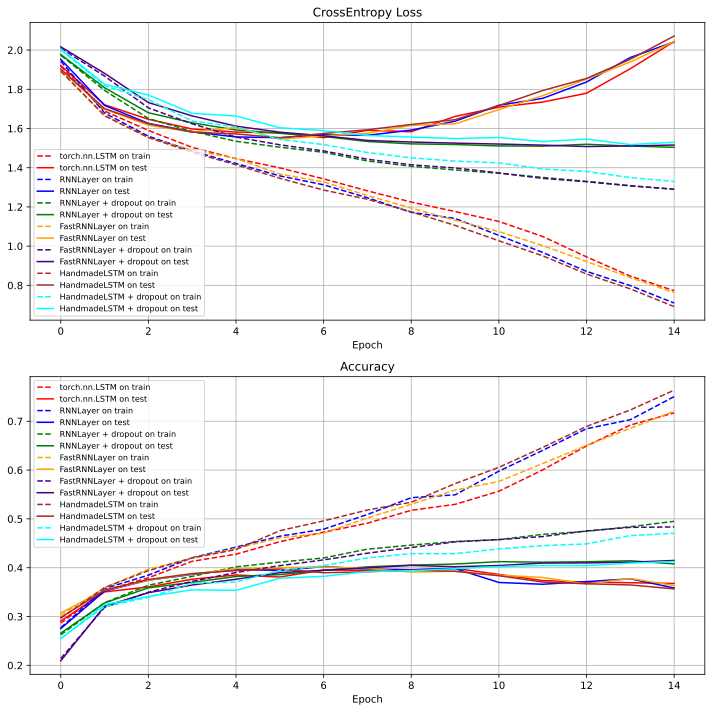

In [121]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

models = ['torch.nn.LSTM', 'RNNLayer', 'RNNLayer + dropout', 'FastRNNLayer', 'FastRNNLayer + dropout',  'HandmadeLSTM', 'HandmadeLSTM + dropout']
colors = ['red', 'blue', 'green', 'orange', 'indigo', 'brown', 'aqua']
for (i, name) in enumerate(models):
    axes[0].plot(history['train_loss'][i], label= str(name) + ' on train', color=colors[i], linestyle='dashed')
    axes[0].plot(history['test_loss'][i], label= str(name) + ' on test', color=colors[i])
    axes[1].plot(history['train_acc'][i], label= str(name) + ' on train', color=colors[i], linestyle='dashed')
    axes[1].plot(history['test_acc'][i], label= str(name) + ' on test', color=colors[i])
    

axes[0].legend(fontsize="8")
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')

axes[1].legend(fontsize="8")
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:**  
Loss на трейне монотонно уменьшается с ростом числа эпох, на тесте: в случае отсутсвия dropout loss сначала уменьшается, а затем увеличивается, что свидетельствует о переобучении модели, а при наличии dropout наблюдается уменьшение loss. Применение dropout на трейне показывает значительное снижение accuracy.  
Наилучшие результаты на трейне демонстрирует HandmadeLSTM: наивысшая accuracy и наименьший loss, однако на тесте наблюдается переобучение. Наилучшие результаты на тесте продемонстрировал RNNLayer + dropout, однако полученная accuracy довольно низкая. 
Самый быстрый подход по времени обучения torch.nn.LSTM и FastRNN, значительно медленнее работает HandmadeLSTM. Dropout несущественно увеличивет время обучения.

## `Бонус. Zoneout (0.5 балла)`

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью $p$ компонента скрытого состояния обновляется, а с вероятностью $1-p$ берется с предыдущего шага. 
В Виде формул ($m^t_h$ - бинарная маска):
 
(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

**Полный балл ставится только при наличии качественного и количественного сравнения с предыдущими моделями.**

In [122]:
class ZoneOut(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        h_t, c_t = init_h0_c0(x.shape[1], self.hidden_size, x)
        
        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        m_x, _ = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)
        h = x.new_empty((x.shape[0], x.shape[1], self.hidden_size))
        for (i, token) in enumerate(m_x * x):
            h_n, c_t = self.rnn_cell(token, (h_t , c_t))
            _, m_h = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)
            h_t = h_n * m_h + h_t * (1 - m_h)
            h[i] = h_t
        return h, (h_t, c_t)

In [123]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=ZoneOut, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
history['time'].append(time.time() - start)
history['train_loss'].append(train_losses_pure)
history['train_acc'].append(train_accuracies_pure)
history['test_loss'].append(test_losses_pure)
history['test_acc'].append(test_accuracies_pure)

Epoch: 1/15. Loss (Train/Test): 2.034/2.035. Accuracy (Train/Test): 0.219/0.226
Epoch: 2/15. Loss (Train/Test): 1.821/1.839. Accuracy (Train/Test): 0.324/0.324
Epoch: 3/15. Loss (Train/Test): 1.664/1.705. Accuracy (Train/Test): 0.361/0.350
Epoch: 4/15. Loss (Train/Test): 1.567/1.638. Accuracy (Train/Test): 0.391/0.368
Epoch: 5/15. Loss (Train/Test): 1.493/1.594. Accuracy (Train/Test): 0.413/0.383
Epoch: 6/15. Loss (Train/Test): 1.438/1.565. Accuracy (Train/Test): 0.434/0.392
Epoch: 7/15. Loss (Train/Test): 1.394/1.565. Accuracy (Train/Test): 0.451/0.398
Epoch: 8/15. Loss (Train/Test): 1.341/1.565. Accuracy (Train/Test): 0.470/0.399
Epoch: 9/15. Loss (Train/Test): 1.297/1.555. Accuracy (Train/Test): 0.488/0.399
Epoch: 10/15. Loss (Train/Test): 1.249/1.576. Accuracy (Train/Test): 0.508/0.400
Epoch: 11/15. Loss (Train/Test): 1.198/1.604. Accuracy (Train/Test): 0.532/0.385
Epoch: 12/15. Loss (Train/Test): 1.132/1.629. Accuracy (Train/Test): 0.565/0.393
Epoch: 13/15. Loss (Train/Test): 1.11

In [124]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=ZoneOut, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()
train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
history['time'].append(time.time() - start)
history['train_loss'].append(train_losses_pure)
history['train_acc'].append(train_accuracies_pure)
history['test_loss'].append(test_losses_pure)
history['test_acc'].append(test_accuracies_pure)

Epoch: 1/15. Loss (Train/Test): 2.058/2.057. Accuracy (Train/Test): 0.206/0.217
Epoch: 2/15. Loss (Train/Test): 1.861/1.872. Accuracy (Train/Test): 0.319/0.320
Epoch: 3/15. Loss (Train/Test): 1.668/1.697. Accuracy (Train/Test): 0.357/0.352
Epoch: 4/15. Loss (Train/Test): 1.608/1.647. Accuracy (Train/Test): 0.380/0.362
Epoch: 5/15. Loss (Train/Test): 1.515/1.574. Accuracy (Train/Test): 0.406/0.387
Epoch: 6/15. Loss (Train/Test): 1.476/1.546. Accuracy (Train/Test): 0.421/0.394
Epoch: 7/15. Loss (Train/Test): 1.439/1.530. Accuracy (Train/Test): 0.435/0.404
Epoch: 8/15. Loss (Train/Test): 1.427/1.530. Accuracy (Train/Test): 0.430/0.405
Epoch: 9/15. Loss (Train/Test): 1.387/1.509. Accuracy (Train/Test): 0.455/0.407
Epoch: 10/15. Loss (Train/Test): 1.372/1.516. Accuracy (Train/Test): 0.455/0.409
Epoch: 11/15. Loss (Train/Test): 1.343/1.509. Accuracy (Train/Test): 0.467/0.412
Epoch: 12/15. Loss (Train/Test): 1.311/1.505. Accuracy (Train/Test): 0.482/0.413
Epoch: 13/15. Loss (Train/Test): 1.29

In [125]:
print(f'ZoneOut without dropout: {history["time"][7]}')
print(f'ZoneOut with dropout = 0.25: {history["time"][8]}')

ZoneOut without dropout: 840.1349854469299
ZoneOut with dropout = 0.25: 885.5828578472137


| без Dropout | c Dropout |
|----------|--------------|
| 14m  | 14m 46s       |

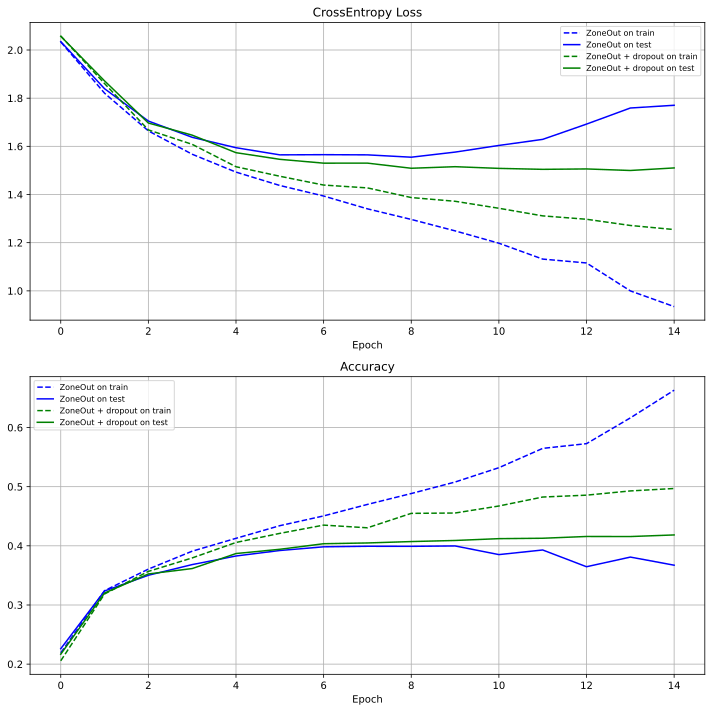

In [126]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

models = ['ZoneOut', 'ZoneOut + dropout']
colors = ['blue', 'green']
for (i, name) in enumerate(models):
    axes[0].plot(history['train_loss'][i + 7], label= str(name) + ' on train', color=colors[i], linestyle='dashed')
    axes[0].plot(history['test_loss'][i + 7], label= str(name) + ' on test', color=colors[i])
    axes[1].plot(history['train_acc'][i + 7], label= str(name) + ' on train', color=colors[i], linestyle='dashed')
    axes[1].plot(history['test_acc'][i + 7], label= str(name) + ' on test', color=colors[i])
    

axes[0].legend(fontsize="8")
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')

axes[1].legend(fontsize="8")
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

В данной реализации время работы возросло по сравнению с использованием RNNLayer или FastRNN, но уменьшилось по сравнению с HandmadeLSTM. Качество на уровне предудыщих реализаций. Данная версия dropout позволяет бороться с переобучением.

# `Часть 2. Language Modeling с помощью LSTM (5 баллов)`

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации — конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

## `Реализация модели и цикла обучения (2 балла)`

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [127]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: 
            Batch of texts represented with tokens. Shape: [T, B]
        :param torch.Tensor(dtype=torch.long) tokens_lens: 
            Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.Tensor: 
            Distribution of next token for each time step. Shape: [T, B, V], V — size of vocabulary
        """
        # Make embeddings for all tokens
        # YOUR CODE HERE
        emb = self.word_embeddings(tokens)
        
        # Forward pass embeddings through network
        # YOUR CODE HERE
        emb = self.rnn(emb)[0]
        
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        # YOUR CODE HERE
        return self.output(emb)


Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [128]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [129]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False).data

tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]])

In [130]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu() - 1, batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tokens_lens.cpu() - 1, batch_first=False, enforce_sorted=False).data
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        # YOUR CODE HERE
        return super().forward(packed_outputs, packed_tokens)

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [131]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu() - 1, batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tokens_lens.cpu() - 1, batch_first=False, enforce_sorted=False).data
        
        return (packed_outputs.argmax(axis=1) == packed_tokens).sum()

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [132]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        # YOUR CODE HERE
        model.zero_grad()
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)
        loss = loss_fn(model(tokens, tokens_lens), tokens, tokens_lens)
        loss.backward()
        optimizer.step()
    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            # YOUR CODE HERE
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)
            pred = model(tokens, tokens_lens)
            total_loss += loss_fn(pred, tokens, tokens_lens).item() * (tokens_lens).sum().item()
            total_accuracy += accuracy_fn(pred, tokens, tokens_lens).item()
            total_tokens += (tokens_lens).sum().item()
            
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [133]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
# min_freq=8 is approximately equivalent to max_size=30000. 
#   You can lower min_freq in order to make model vocabulary more diverse 
lm_vocab = torchtext.vocab.vocab(counter, specials=specials, special_first=True, min_freq=8)
lm_vocab.set_default_index(vocab['<unk>'])

In [134]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [135]:
warnings.filterwarnings("ignore")

lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=3, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=3, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце — `<eos>` токен.

In [136]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [26597,   727,    60,  ...,   746,    23, 15178],
         [   46,  5151,   307,  ...,    19,  3086,  1577],
         ...,
         [ 1551,  3435,   686,  ...,   754,  1316,  3927],
         [  652,  1930,    39,  ...,   182,   160,   603],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
         22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
         22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
         22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
         22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
         22, 22, 22, 22, 22, 22]))

Создадим модель, функцию потерь и оптимизатор: 

In [137]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [138]:
lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [139]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)

Epoch: 1/10. Loss (Train/Test): 7.616/7.740. Accuracy (Train/Test): 0.069/0.069
Epoch: 2/10. Loss (Train/Test): 7.372/7.576. Accuracy (Train/Test): 0.078/0.077
Epoch: 3/10. Loss (Train/Test): 7.154/7.458. Accuracy (Train/Test): 0.086/0.085
Epoch: 4/10. Loss (Train/Test): 6.960/7.388. Accuracy (Train/Test): 0.090/0.088
Epoch: 5/10. Loss (Train/Test): 6.774/7.354. Accuracy (Train/Test): 0.095/0.091
Epoch: 6/10. Loss (Train/Test): 6.592/7.332. Accuracy (Train/Test): 0.101/0.095
Epoch: 7/10. Loss (Train/Test): 6.449/7.352. Accuracy (Train/Test): 0.104/0.096
Epoch: 8/10. Loss (Train/Test): 6.282/7.348. Accuracy (Train/Test): 0.109/0.097
Epoch: 9/10. Loss (Train/Test): 6.123/7.358. Accuracy (Train/Test): 0.113/0.098
Epoch: 10/10. Loss (Train/Test): 5.987/7.392. Accuracy (Train/Test): 0.117/0.099


## `Реализация декодера (1 балл)`

Теперь, реализуем последнюю деталь — декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [140]:
@torch.no_grad()
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum lenght of generated samples
    :param Optional[int] top_k: Number of tokens with the largest probability to sample from
    :return Tuple[torch.Tensor, torch.Tensor]. 
        Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    # YOUR CODE HERE
    embedding = model.word_embeddings(start_tokens)
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        _, (h, c) = model.rnn(embedding[time_step][None,], (h, c))
        all_h.append(h)
        all_c.append(c)
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = model.output(h[-1])
        
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token. 
            # YOUR CODE HERE
            next_token = torch.distributions.categorical.Categorical(logits=logits).sample()
        else:
            # Select most probable token
            # YOUR CODE HERE
            next_token = logits.argmax(axis=1)
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Compute embedding for next token
        # YOUR CODE HERE
        embedding = model.word_embeddings(next_token)
        
        # Update hidden and cell states
        # YOUR CODE HERE
        _, (h, c) = model.rnn(embedding[None,], (h, c))
        
    return torch.stack(predicted_tokens), decoded_lens

Попробуем сгенерировать продолжения для нескольких префиксов:

In [141]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [142]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)

In [143]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> film one best films ever seen seen long time see movie first saw film first time hooked thought film funny
<sos> <unk> favorite movie first time saw movie years ago still enjoyed good movie great acting great actors great story line great <eos>
<sos> <unk> best movie ever seen movie even though movie really bad even though one worst movies ever made bad acting bad special effects
<sos> <unk> worst movie time ever watched life every time saw movie theater time watched film thought would good movie bad acting terrible story


Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

## Жадное декодирование

In [144]:
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None)
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie one best movies ever seen life movie really bad movie bad acting bad acting bad special effects bad special
<sos> <unk> favorite movie seen long time ago saw movie first time saw movie theater first time saw movie theater first time saw movie
<sos> <unk> best movie ever seen movie seen long time saw movie theater first time saw movie theater first time saw movie theater first
<sos> <unk> worst movie ever seen life even worse movie bad acting bad acting bad special effects bad special effects bad <eos>


In [145]:
for k in range(1, 30, 3):
    print('top_k =', k)
    decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))

top_k = 1
<sos> movie one best movies ever seen life movie really bad movie bad acting bad acting bad special effects bad special
<sos> <unk> favorite movie seen long time ago saw movie first time saw movie theater first time saw movie theater first time saw movie
<sos> <unk> best movie ever seen movie seen long time saw movie theater first time saw movie theater first time saw movie theater first
<sos> <unk> worst movie ever seen life even worse movie bad acting bad acting bad special effects bad special effects bad <eos>
top_k = 4
<sos> movie bad bad bad movie bad acting bad acting bad directing terrible special effects awful special effects bad acting bad
<sos> <unk> favorite movie time one best movies ever seen life one best movies ever seen one favorites great movie really deserves movie <eos>
<sos> <unk> best movie seen long time see <unk> <unk> movie <unk> one favorite movie ever seen movie great acting great acting <eos>
<sos> <unk> worst movie seen long time life one thing eve

**Ответ:**  
Жадное декодирование совпадается со стратегией top_k = 1. С ростом параметра top_k предложения становятся более разнообразными, начинают чаще встречаться токены <unk>, что свидетельствует о том, что используются слова, которые нечасто встречаются в словаре. Конструкции в предложениях становятся сложнее: вместо "bad movie bad acting bad acting bad special effects bad special" генерируется "bad special effects terrible story weak characters bad acting horrible directing laughable way movie".

## `Beam Search (2 балла)`

Рассмотрим более продвинутый алгоритм для декодирования. Реализуйте алгоритм Beam Search.

Несколько замечаний по имплементации:

1. При больших размерах `beam_size` число гипотез ($B \times \text{beam\_size}$) на очередном шаге может быть слишком большим. Поэтому может потребоваться разбить все гипотезы на отдельные батчи и делать forward-pass в несколько итераций. Используйте [`torch.split`](https://pytorch.org/docs/stable/generated/torch.split.html)
2. Для выбора лучших гипотез используйте [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html). Обратите внимание на индексы, которые возвращает эта функция (может пригодиться метод [`torch.remainder`](https://pytorch.org/docs/stable/generated/torch.remainder.html))
3. Можно отслеживать, какие элементы в батче (или какие гипотезы) закончили генерацию. Делая forward-pass только для незавершённых гипотез, можно ускорить декодинг, однако, это усложнит реализацию

In [146]:
@torch.no_grad()
def decode_beam_search(model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=5):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum length of generated samples
    :param int beam_size: Size of beam
    :return Tuple[torch.Tensor, torch.Tensor, torch.Tensor]. 
        Newly predicted tokens, probabilities for each hypotheses and lengths of generated parts
        Shape [T*, B, beam_size], [B, beam_size], [B, beam_size]
    """
 
    # 1. Initialize beams and hypotheses probabilities for each element in the batch
    # 2. While all sequences do not end with <eos> and their length less than max_generated_len
    #    1. Perform forward pass and obtain probabilities for all extensions
    #    2. Compute probabilities for all hypotheses
    #    3. Select top-beam_size hypotheses for each element in the batch
    #    4. Take tokens that correspond to the chosen hypotheses
    #    5. Concat new tokens to existing prefixes
    # YOUR CODE HERE
 
    # START CODE FROM TOPK
    embedding = model.word_embeddings(start_tokens)
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        x, (h, c) = model.rnn(embedding[time_step].unsqueeze(dim=0), (h, c))
        all_h.append(h)
        all_c.append(c)
 
    all_h = torch.stack(all_h, dim=1) 
    all_c = torch.stack(all_c, dim=1)
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])] 
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    decoded_lens = torch.ones((start_tokens_lens.size(0), beam_size), dtype=torch.long)
    is_finished_decoding = torch.zeros((start_tokens_lens.size(0), beam_size), dtype=torch.bool)
    # END CODE FROM TOPK
 
    cur_logprobs = torch.log(torch.softmax(model.output(h[-1]), dim=1))
    new_logsprobs, a = torch.topk(cur_logprobs, beam_size)
    h_new = torch.zeros((beam_size, h.size(0), h.size(1), h.size(2)))
    c_new = torch.zeros((beam_size, h.size(0), h.size(1), h.size(2)))
    res = torch.zeros((1, h.size(1), beam_size), dtype=torch.long)
    for beam_idx in range(beam_size):
        h_new[beam_idx] = h
        c_new[beam_idx] = c
        res[:, :, beam_idx] = a[:, beam_idx]
 
    h, c = h_new, c_new
    probs = new_logsprobs
    mask = torch.zeros((res.size(1), beam_size), dtype=torch.long)
    mask += torch.arange(res.size(1))[:, None]
 
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        hs, cs, pr, ind = [], [], [], []
        for beam_idx in range(beam_size):
            next_token_embed = model.word_embeddings(res[-1, :, beam_idx])
            x, (h_new, c_new) = model.rnn(next_token_embed.unsqueeze(dim=0), (h[beam_idx], c[beam_idx]))
            hs.append(h_new)
            cs.append(c_new)
            new_probs = torch.log(torch.softmax(model.output(h_new[-1]), dim=1)) 
            new_probs = new_probs + probs[:, beam_idx][:, None]
            new_probs, a = torch.topk(new_probs, beam_size)
            pr.append(new_probs)
            ind.append(a)
 
        pr = torch.flatten(torch.stack(pr, dim=1), start_dim=1) 
        ind = torch.flatten(torch.stack(ind, dim=1), start_dim=1) 
        ap, bi = torch.topk(pr, beam_size)
        probs = ap
        ind_batch = bi // beam_size
        res = res[:, mask, ind_batch]
        new_part = ind[mask, bi]
        res = torch.concatenate([res, new_part[None,]], dim=0)
        # update h, c
        hs = torch.stack(hs, dim=0) 
        cs = torch.stack(cs, dim=0)
        tmp = torch.permute(hs, (1, 3, 2, 0))[:, :, mask, ind_batch]
        h = torch.permute(tmp, (3, 0, 2, 1))
        tmp = torch.permute(cs, (1, 3, 2, 0))[:, :, mask, ind_batch]
        c = torch.permute(tmp, (3, 0, 2, 1))
        is_finished_decoding = is_finished_decoding[mask, ind_batch]
        decoded_lens = decoded_lens[mask, ind_batch]
 
        is_finished_decoding |= (new_part == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))
        decoded_lens += (~is_finished_decoding)
 
    return res, probs, decoded_lens

Попробуйте выполнить декодинг для разных `beam_size`. Убедитесь, что при `beam_search=1` семплирование совпадает с top-1 (greedy decoding) подходом. 

Сравните результаты Beam Search с top-k семплированием и жадным декодированием. Опишите ваши наблюдения.

In [147]:
decoded_tokens, probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=1)
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx, 0], text_idx, 0]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie one best movies ever seen life movie really bad movie bad acting bad acting bad special effects bad special
<sos> <unk> favorite movie seen long time ago saw movie first time saw movie theater first time saw movie theater first time saw movie
<sos> <unk> best movie ever seen movie seen long time saw movie theater first time saw movie theater first time saw movie theater first
<sos> <unk> worst movie ever seen life even worse movie bad acting bad acting bad special effects bad special effects bad


Выводы beam search и topk=1 совпадают $\Rightarrow$ реализация корректна!

In [148]:
for k in range(1, 52, 10):
    print('beam_size =', k)
    decoded_tokens, probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=k)
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx, 0] + 1, text_idx, 0]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))

beam_size = 1
<sos> movie one best movies ever seen life movie really bad movie bad acting bad acting bad special effects bad special
<sos> <unk> favorite movie seen long time ago saw movie first time saw movie theater first time saw movie theater first time saw movie
<sos> <unk> best movie ever seen movie seen long time saw movie theater first time saw movie theater first time saw movie theater first
<sos> <unk> worst movie ever seen life even worse movie bad acting bad acting bad special effects bad special effects bad <eos>
beam_size = 11
<sos> one worst movies ever seen bad acting bad directing bad special effects bad acting bad special effects bad special effects
<sos> <unk> favorite movie one best movies seen long time one best movies ever seen first time saw first time saw movie years ago
<sos> <unk> best movie ever seen one best movies ever seen first time saw first time saw movie first time saw movie years ago
<sos> <unk> worst movie ever seen bad acting bad special effects ba

Для beam_size=1, 11, 21 получились различные продолжения. Так как данные предложения имеют небольшую длину, то с какого-то момента beam_search забывает про начальный контекст и начинает продолжать предложениям самыми вероятными последовательностями. Так, для beam_size=51, продолжения содержат повторяющиеся последовательности, обладающие большой вероятностью `bad acting bad special effects`.

Отсюда можно сделать следующие выводы:
1. Для beam_search важно, чтобы исходные предложения были приемлиемой длины.  
2. Увеличение beam_size не всегда приводит к повышению качества генерации.  

In [153]:
decoded_tokens, probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=5)
for text_idx in range(start_tokens.shape[1]):
    print('sentence', text_idx + 1)
    for k in range(4):
        print('log prob =', probs[text_idx, k].item())
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx, k] + 1, text_idx, k]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))
    print()

sentence 1
log prob = -33.9821891784668
<sos> one worst movies ever seen bad acting bad acting bad directing bad special effects bad special effects bad special effects
log prob = -35.23361587524414
<sos> one worst movies ever seen bad acting bad directing bad acting bad directing bad special effects bad special effects bad
log prob = -35.46843719482422
<sos> one worst movies ever seen bad acting bad acting bad directing bad special effects bad special effects bad acting bad
log prob = -36.37767028808594
<sos> one worst movies ever seen bad acting bad acting bad directing bad special effects bad special effects bad story line

sentence 2
log prob = -44.016273498535156
<sos> <unk> favorite movie first time saw movie first time saw movie first time saw movie first time saw movie first time saw movie
log prob = -45.11638259887695
<sos> <unk> favorite movie first time saw movie first time saw movie first time saw movie first time saw first time saw movie theater
log prob = -45.319339752197

## `Бонус. Существенное улучшение качества (до 6 баллов)`

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов **(+0.25)**
2. Dropout входов и выходов RNN **(+0.25)**
3. Регуляризация активаций (AR/TAR) **(+1.0)**
4. NT-ASGD **(+1.5)**
5. Tied веса эмбеддингов и софтмакса **(+1.0)**
6. Attention **(+2.0)**

**Полные баллы ставятся только при наличии качественного и количественного сравнения с бейзлайном.**

**Для эксперимента с Attention необходимо изобразить Attention Maps для нескольких примеров.**